# Evaluations of PyTorch Extension API of Kernels

## Assistant function: l2 cache flusher

In [1]:
import pycuda.driver as cuda

class L2Flush:
    def __init__(self):
        cuda.init()
        self.device = cuda.Device(1)
        self.context = self.device.make_context()
        self.m_l2_size = self.device.get_attribute(cuda.device_attribute.L2_CACHE_SIZE)
        if self.m_l2_size > 0:
            print("device L2 cache size: %d MB" % (self.m_l2_size / 1024 / 1024))
            self.m_l2_buffer = cuda.mem_alloc(self.m_l2_size)

    def __del__(self):
        if self.m_l2_buffer:
            self.m_l2_buffer.free()

        # Detach the CUDA context when the object is deleted
        self.context.pop()

    def flush(self, stream):
        if self.m_l2_size > 0:
            self.context.push()
            cuda.memset_d8_async(self.m_l2_buffer, 0, self.m_l2_size, stream)
            self.context.pop()
l2Flusher = L2Flush()
l2Flusher.flush(cuda.Stream(0))

device L2 cache size: 72 MB


## W8A8 Kernel Evaluation

In [2]:
import torch

# set torch device as 1. Since RTX4090 is 1 on our local machine.
torch.cuda.set_device(1)

test_M_pool = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

In [7]:
import torch
from torch_int._CUDA import linear_a8_w8_b8_o8

@torch.no_grad()
def test_quant_linear_a8_w8_b8_o8(M,N,K):
    # Init inputs with corresponding shapes
    # Ref: https://github.com/Guangxuan-Xiao/torch-int/blob/main/torch_int/kernels/linear.cu#L369

    weight = torch.randint(-128, 127, (N, K), dtype=torch.int8).cuda()
    bias = torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(
        torch.int8).max, (N,), dtype=torch.int8).cuda()
    x = torch.randint(-128, 127, (M, K), dtype=torch.int8).cuda()

    torch.cuda.synchronize()

    elapsed_time_ms = 0
    iterations = 30

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = linear_a8_w8_b8_o8(x, weight, bias, 1, 1)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

w8a8_flops = []
for m in test_M_pool:
    gflops, elapsed_time_ms = test_quant_linear_a8_w8_b8_o8(m, 4096, 4096)
    w8a8_flops.append(gflops)

print(w8a8_flops)

[2.928233438775072, 6.058944027846304, 12.147133542431966, 24.49705443214467, 49.57134767891193, 99.02931334169796, 192.23851561133415, 369.4828550922088, 433.98997666107266]


## W4A16 Kernel Evaluation

In [10]:
import torch
from awq_inference_engine import gemv_forward_cuda

@torch.no_grad()
def test_quant_linear_a16_w4_gemv(M, N, K):
    groupSize = 128

    # Init inputs with corresponding shapes
    # Ref: https://github.com/mit-han-lab/llm-awq/blob/main/awq/kernels/csrc/quantization/gemv_cuda.cu#L189

    x = torch.rand(M, K, dtype=torch.float16, device='cuda')
    weight = torch.randint(0, 128, (N, K // 8), dtype=torch.int32, device='cuda')
    scailing = torch.rand(N, K // groupSize, dtype=torch.float16, device='cuda')
    zeros = torch.randint(0,128,(N, K // groupSize // 8), dtype=torch.int32, device='cuda')
    
    elapsed_time_ms = 0
    iterations = 30

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = gemv_forward_cuda(x, weight, scailing, zeros, groupSize)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

a16w4_flops = []
for m in test_M_pool:
    gflops, elapsed_time_ms = test_quant_linear_a16_w4_gemv(m, 4096, 4096)
    a16w4_flops.append(gflops)

print(a16w4_flops)

[5.093059212625437, 6.536323152461491, 7.543259966351492, 7.947865778756361, 8.344728762237368, 8.54029590437908, 8.499885651479563, 8.183972536588632, 8.167991369592459]


## FP16 Baseline Evaluation

In [13]:
import torch
from torch.nn import functional as F

@torch.no_grad()
def test_quant_linear_a16_w16(M, N ,K) -> float:
    weight = torch.rand(K, N, dtype=torch.float16).cuda()
    x = torch.rand(M, K, dtype=torch.float16).cuda()

    elapsed_time_ms = 0
    iterations = 30
    
    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = F.linear(x, weight)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        l2Flusher.flush(cuda.Stream(0))
    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

a16w16_flops = []
for m in test_M_pool:
    gflops, elapsed_time_ms = test_quant_linear_a16_w16(m, 4096, 4096)
    a16w16_flops.append(gflops)

print(a16w16_flops)

[3.5913723582696826, 7.396274389981544, 14.601368378822112, 29.153260582063147, 55.5314758714023, 95.79681813261212, 136.6930123791791, 152.77694542825068, 161.1156499269412]


## Atom (Our W4A4) GEMM Kernel Evaluation

In [12]:
import torch
from punica.ops import dense_layer_gemm_i4_fp16
from punica.ops import scale_size

@torch.no_grad()
def test_quant_our_w4a4_gemm(M):
    bs = M
    hidden_dim = 4096
    group_size = 128

    a = torch.randint(
        16,
        128, (bs, (hidden_dim - group_size) // 2),
        dtype=torch.uint8).cuda()
    b = torch.randint(
        16,
        128, (hidden_dim, (hidden_dim - group_size) // 2),
        dtype=torch.uint8).cuda()
    a_scale = torch.randn((hidden_dim // group_size - 1, scale_size(bs)),
                            dtype=torch.float16).cuda()
    b_scale = torch.randn((hidden_dim // group_size - 1, scale_size(bs)),
                            dtype=torch.float16).cuda()
    a_keeper = torch.randint(
        0, 255, (bs, group_size), dtype=torch.uint8).cuda()
    b_keeper = torch.randint(
        0, 255, (bs, group_size), dtype=torch.uint8).cuda()
    a_keeper_scale = torch.randn((scale_size(bs),),
                                dtype=torch.float16).cuda()
    b_keeper_scale = torch.randn((scale_size(bs),),
                                dtype=torch.float16).cuda()

    iterations = 30
    elapsed_time_ms = 0
    
    for _ in range(iterations):
        torch.cuda.synchronize()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        y = dense_layer_gemm_i4_fp16(a, b, a_scale, b_scale, a_keeper,
                                    b_keeper, a_keeper_scale, b_keeper_scale)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        l2Flusher.flush(cuda.Stream(0))

    total_ops = M * hidden_dim * hidden_dim * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

w4a4_flops = []
for m in test_M_pool:
    gflops, elapsed_time_ms = test_quant_our_w4a4_gemm(m)
    w4a4_flops.append(gflops)

print(w4a4_flops)

[6.644442034767834, 13.6618572262898, 27.373496811519512, 54.63260018922175, 108.40621174030697, 211.1060843567243, 375.1194162714706, 464.8434121405477, 539.3925668781076]


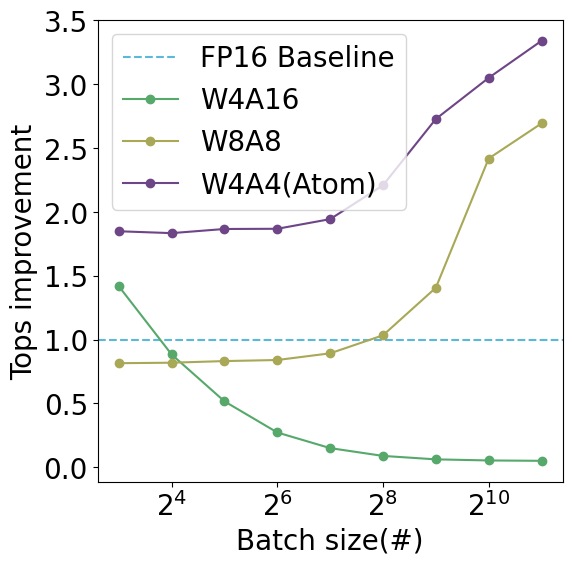

In [11]:
ai = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
fp16 = [3.5913723582696826, 7.396274389981544, 14.601368378822112, 29.153260582063147, 55.5314758714023, 95.79681813261212, 136.6930123791791, 152.77694542825068, 161.1156499269412]
w4a4 = [6.639533644869575, 13.565385101531655, 27.254175615471844, 54.4611666014685, 107.93834080480016, 211.59420293722238, 372.91334478435743, 466.0135395676664, 538.1759856711493]
w4a16 =[5.093059212625437, 6.536323152461491, 7.543259966351492, 7.947865778756361, 8.344728762237368, 8.54029590437908, 8.499885651479563, 8.183972536588632, 8.167991369592459]
w8a8 = [2.928233438775072, 6.058944027846304, 12.147133542431966, 24.49705443214467, 49.57134767891193, 99.02931334169796, 192.23851561133415, 369.4828550922088, 433.98997666107266]

import matplotlib.pyplot as plt
bar_colors_default = ["#5BB8D7", "#57A86B", "#A8A857", "#6E4587", "#ADEBCC", "#EBDCAD"]
# set font size
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(6, 6))
for i in range(len(ai)):
    w4a4[i] = w4a4[i] / fp16[i]
    w4a16[i] = w4a16[i] / fp16[i]
    w8a8[i] = w8a8[i] / fp16[i]
plt.axhline(y=1, color=bar_colors_default[0], linestyle='--', label='FP16 Baseline')
plt.plot(ai, w4a16, label='W4A16', marker='o', color=bar_colors_default[1])
plt.plot(ai, w8a8, label='W8A8', marker='o', color=bar_colors_default[2])
plt.plot(ai, w4a4, label='W4A4(Atom)', marker='o', color=bar_colors_default[3])
plt.xscale('log', base=2)
plt.legend()
plt.xlabel('Batch size(#)')
plt.ylabel('Tops improvement')
plt.show()
plt.close()